<a href="https://colab.research.google.com/github/thanhtrinh2003/GarbageClassificationKaggle/blob/main/garbage_classification_self_written_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn import model_selection
import tensorflow as tf
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow


INPUT IMAGES

In [4]:
labels = ['cardboard', 'glass','plastic','paper','metal','trash']
img_size = 224
data_dir ='/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/'
data = []

nb = {'cardboard':404, 'glass': 502, 'plastic': 483 , 'paper': 595 , 'metal': 411, 'trash':138}

for label in labels:
  path = data_dir + label + "/" +label
  class_num = labels.index(label)
  for i in tqdm(range(1,nb[label])):
    img_arr = cv.imread(path+str(i)+".jpg")[...,::-1]
    resized_arr = cv.resize(img_arr, (img_size, img_size))
    data.append([resized_arr, class_num])

100%|██████████| 137/137 [01:06<00:00,  2.06it/s]


In [5]:
train, test = model_selection.train_test_split(data, test_size = 0.15)
train, val = model_selection.train_test_split(train, test_size = 0.15/0.85)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


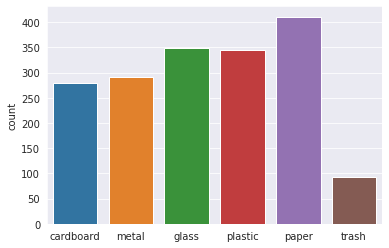

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("cardboard")
    elif(i[1] == 1):
        l.append("glass")
    elif(i[1] == 2):
        l.append("plastic")
    elif(i[1] == 3):
        l.append("paper")
    elif(i[1] == 4):
        l.append("metal")
    else:
        l.append("trash")
sns.set_style('darkgrid')
sns.countplot(l)

In [7]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [37]:
class ResNet:
  @staticmethod
  def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
    #the shortcut branch of the Resnet module should be initialize as the input(indentity) data
    shortcut = data

    #the first block of the Resnet module are the 1*1 CONVs
    bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
    act1 = Activation("relu")(bn1)
    conv1 = Conv2D(int(K*0.25), (1,1), use_bias=False, kernel_regularizer=l2(reg))(act1)

    #the second block of the ResNet module are the 3x3 CONVs
    bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
    act2 = Activation("relu")(bn2)
    conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg))(act2)

    # the third block of the ResNet module is another set of 1x1 CONVs
    bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
    act3 = Activation("relu")(bn3)
    conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)

    #if we are to reduce the spatial size, apply a CONV layer to the shortcut
    if red:
      shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)

    # add together the shortcut and the final CONV
    x = add([conv3, shortcut])

    # return the addition as the output of the ResNet module
    return x

  @staticmethod
  def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
    # initialize the input shape to be "channels last" and the
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    
    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1

    # set the input and apply BN
    inputs = Input(shape=inputShape)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(inputs)
    
    # apply CONV => BN => ACT => POOL to reduce spatial size
    x = ZeroPadding2D(padding = (3,3))(x)
    x = Conv2D(filters[0], (7, 7), strides=(2,2), use_bias=False, padding="valid", kernel_regularizer=l2(reg))(x)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = ZeroPadding2D((1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # loop over the number of stages
    for i in range(0, len(stages)):
      # initialize the stride, then apply a residual module
      # used to reduce the spatial size of the input volume	
      print(x)
      stride = (1, 1) if i == 0 else (2, 2)
      x = ResNet.residual_module(x, filters[i + 1], stride,chanDim, red=True, bnEps=bnEps, bnMom=bnMom)
      
      # loop over the number of layers in the stage
      for j in range(0, stages[i] - 1):
        # apply a ResNet module
        x = ResNet.residual_module(x, filters[i + 1],(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
    
    # apply BN => ACT => POOL
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((7, 7))(x)
    
    # softmax classifier
    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg))(x)
    x = Activation("softmax")(x)
    
    # create the model
    model = Model(inputs, x, name="resnet")
    
    # return the constructed network architecture
    return model


In [38]:
model = ResNet.build(224, 224, 3, 6, stages = [3,4,6,3], filters= [64,256,512,1024,2048])


KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 64), dtype=tf.float32, name=None), name='tf.compat.v1.nn.max_pool_8/MaxPool:0', description="created by layer 'tf.compat.v1.nn.max_pool_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_130/AddV2:0', description="created by layer 'tf.__operators__.add_130'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='tf.__operators__.add_134/AddV2:0', description="created by layer 'tf.__operators__.add_134'")
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 1024), dtype=tf.float32, name=None), name='tf.__operators__.add_140/AddV2:0', description="created by layer 'tf.__operators__.add_140'")


OLD


In [39]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_412 (BatchN (None, 224, 224, 3)  12          input_13[0][0]                   
__________________________________________________________________________________________________
tf.compat.v1.pad_9 (TFOpLambda) (None, 230, 230, 3)  0           batch_normalization_412[0][0]    
__________________________________________________________________________________________________
conv2d_426 (Conv2D)             (None, 112, 112, 64) 9408        tf.compat.v1.pad_9[0][0]         
_____________________________________________________________________________________________

In [40]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() ,
              optimizer='Adam',
              metrics=['accuracy'])

In [41]:
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500
56/56 [==============================] - 16s 156ms/step - loss: 3.3970 - accuracy: 0.4299 - val_loss: 3.3008 - val_accuracy: 0.4142
Epoch 2/500
56/56 [==============================] - 7s 121ms/step - loss: 2.9562 - accuracy: 0.5226 - val_loss: 3.5887 - val_accuracy: 0.4908
Epoch 3/500
56/56 [==============================] - 7s 121ms/step - loss: 2.8006 - accuracy: 0.5396 - val_loss: 2.8766 - val_accuracy: 0.5409
Epoch 4/500
56/56 [==============================] - 7s 121ms/step - loss: 2.5736 - accuracy: 0.5730 - val_loss: 2.6301 - val_accuracy: 0.5646
Epoch 5/500
56/56 [==============================] - 7s 121ms/step - loss: 2.3057 - accuracy: 0.6380 - val_loss: 3.2883 - val_accuracy: 0.5172
Epoch 6/500
56/56 [==============================] - 7s 121ms/step - loss: 2.1430 - accuracy: 0.6307 - val_loss: 2.1483 - val_accuracy: 0.6253
Epoch 7/500
56/56 [==============================] - 7s 121ms/step - loss: 2.0120 - accuracy: 0.6420 - val_loss: 2.0983 - val_accuracy: 0.604

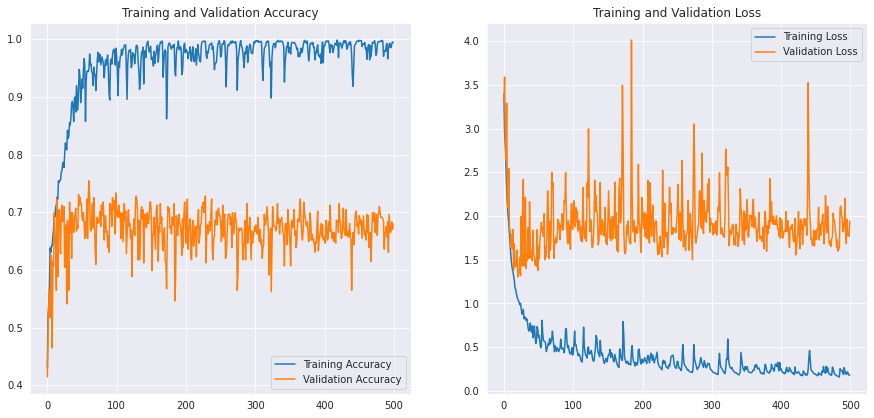

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
test_scores = model.evaluate(x_test, y_test, verbose=2)

12/12 - 1s - loss: 1.9678 - accuracy: 0.6737


In [44]:
print("Test loss:", str(test_scores[0]))
print("Test accuracy:", str(test_scores[1]))

Test loss: 1.9678359031677246
Test accuracy: 0.6736842393875122


In [3]:
class ResNet34:
  @staticmethod
  def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
    #the shortcut branch of the Resnet module should be initialize as the input(indentity) data
    shortcut = data

    #the first block of the Resnet module are the 1*1 CONVs
    bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
    act1 = Activation("relu")(bn1)
    conv1 = Conv2D(int(K), (3, 3), use_bias=False, kernel_regularizer=l2(reg))(act1)

    #the second block of the ResNet module are the 3x3 CONVs
    bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
    act2 = Activation("relu")(bn2)
    conv2 = Conv2D(int(K), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg))(act2)

    #if we are to reduce the spatial size, apply a CONV layer to the shortcut
    if red:
      shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)

    # add together the shortcut and the final CONV
    x = add([conv3, shortcut])

    # return the addition as the output of the ResNet module
    return x

  @staticmethod
  def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
    # initialize the input shape to be "channels last" and the
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    
    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1

    # set the input and apply BN
    inputs = Input(shape=inputShape)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(inputs)
    
    # apply CONV => BN => ACT => POOL to reduce spatial size
    x = Conv2D(filters[0], (7, 7), use_bias=False,padding="same", kernel_regularizer=l2(reg))(x)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = ZeroPadding2D((1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # loop over the number of stages
    for i in range(0, len(stages)):
      # initialize the stride, then apply a residual module
      # used to reduce the spatial size of the input volume	
      print(x)
      stride = (1, 1) if i == 0 else (2, 2)
      x = ResNet.residual_module(x, filters[i + 1], stride,chanDim, red=True, bnEps=bnEps, bnMom=bnMom)
      
      # loop over the number of layers in the stage
      for j in range(0, stages[i] - 1):
        # apply a ResNet module
        x = ResNet.residual_module(x, filters[i + 1],(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
    
    # apply BN => ACT => POOL
    x = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((8, 8))(x)
    
    # softmax classifier
    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg))(x)
    x = Activation("softmax")(x)
    
    # create the model
    model = Model(inputs, x, name="resnet")
    
    # return the constructed network architecture
    return model


In [46]:
while True:
  print(1)

Streaming output truncated to the last 5000 lines.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

KeyboardInterrupt: ignored